In [1]:
import rawpy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import trange
from calibrate import single_calibrate, stereo_calibrate
from PIL import Image
from PIL import ImageEnhance

In [2]:
path = "test_images"
cam1 = "1.png"
cam2 = "DSCF9208.RAF" 

In [3]:
def generate_masked_image(image, p1, p2, preview=None):
    # generate a mask
    mask = np.zeros(image.shape, dtype=np.uint8)
    mask = cv2.rectangle(mask, p1, p2, (255, 255, 255), -1)
    masked_image = cv2.bitwise_and(image, mask)
    if preview is not None:
        mask_preview = cv2.rectangle(np.zeros(image.shape, dtype=np.uint8), p1, p2, (255, 0, 0), -1)
        mask_preview = cv2.addWeighted(image, 0.8, mask_preview, 0.2, 0)
        mask_preview = cv2.cvtColor(mask_preview, cv2.COLOR_RGB2BGR)
        os.makedirs(os.path.join(path, "ref"), exist_ok=True)
        cv2.imwrite(os.path.join(path, "ref", preview+".jpg"), mask_preview)
    return masked_image

def rgb_to_srgb(image, max_value = -1):
    if max_value == -1:
        if image.dtype == np.uint8:
            max_value = 255
        elif image.dtype == np.uint16:
            max_value = 65535
        elif image.dtype == np.float32:
            max_value = 1
        else:
            raise ValueError("Unknown image type.")
    ret = image.astype(np.float32)
    ret /= max_value
    ret = np.where(ret > 0.0031308, 1.055 *
                   np.power(ret.clip(min=0.0031308), 1 / 2.4) - 0.055, 12.92 * ret)
    ret *= max_value
    ret = ret.astype(image.dtype)
    ret = np.maximum(ret, 0)
    ret = np.minimum(ret, max_value)
    return ret

40 20 1550 1170 1150 1510


C:\Users\ecoplants\AppData\Local\Temp\ipykernel_26836\2539371411.py:2: DeprecationWarning: ROTATE_180 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_180 instead.
  img1 = img1.transpose(Image.ROTATE_180)


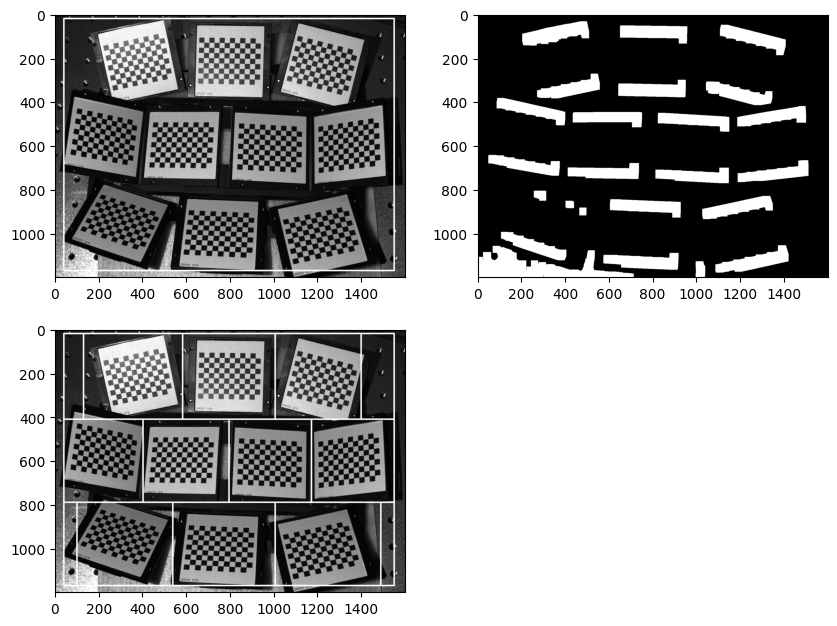

In [4]:
img1 = Image.open(os.path.join(path, cam1))
img1 = img1.transpose(Image.ROTATE_180)
img1 = np.asarray(img1)[:, 160:-160, :3]

img = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# do morphological opening to remove noise and invert image
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=15)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = np.array([cv2.boundingRect(c) for c in contours])
bounding_boxes[:, 2:] += bounding_boxes[:, :2]

x1 = np.min(bounding_boxes[:, 0])
y1 = np.min(bounding_boxes[:, 1])
x2 = np.max(bounding_boxes[:, 2])
y2 = np.max(bounding_boxes[:, 3])

x1, y1, x2, y2 = 40, 20, 1550, 1170
h, w = y2-y1, x2-x1
print(x1, y1, x2, y2, h, w)

cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 5)

plt.figure(figsize=(10, 7.5))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(thresh, cmap="gray")

h0, h1, h2, h3 = 0, 0.34, 0.67, 1
w0, w1, w2, w3 = 0.06, 0.36, 0.64, 0.90
w4, w5, w6 = 0.24, 0.5, 0.75
w7, w8, w9, w10 = 0.04, 0.33, 0.64, 0.96

cam1_p1 = [
    [[y1+h0*h, x1+w0*w], [y1+h1*h, x1+w1*w]],
    [[y1+h0*h, x1+w1*w], [y1+h1*h, x1+w2*w]],
    [[y1+h0*h, x1+w2*w], [y1+h1*h, x1+w3*w]],

    [[y1+h1*h, x1], [y1+h2*h, x1+w4*w]],
    [[y1+h1*h, x1+w4*w], [y1+h2*h, x1+w5*w]],
    [[y1+h1*h, x1+w5*w], [y1+h2*h, x1+w6*w]],
    [[y1+h1*h, x1+w6*w], [y1+h2*h, x1+w]],

    [[y1+h2*h, x1+w7*w], [y1+h3*h, x1+w8*w]],
    [[y1+h2*h, x1+w8*w], [y1+h3*h, x1+w9*w]],
    [[y1+h2*h, x1+w9*w], [y1+h3*h, x1+w10*w]],
]

# convert to int numpy array
cam1_p1 = np.asarray(cam1_p1, dtype=np.int32)

cam1_p1 = cam1_p1[:, :, ::-1]

for b in cam1_p1:
    cv2.rectangle(img, b[0], b[1], (255, 0, 0), 5)

plt.subplot(2, 2, 3)
plt.imshow(img, cmap="gray")

3000 2000 7600 5700 3700 4600


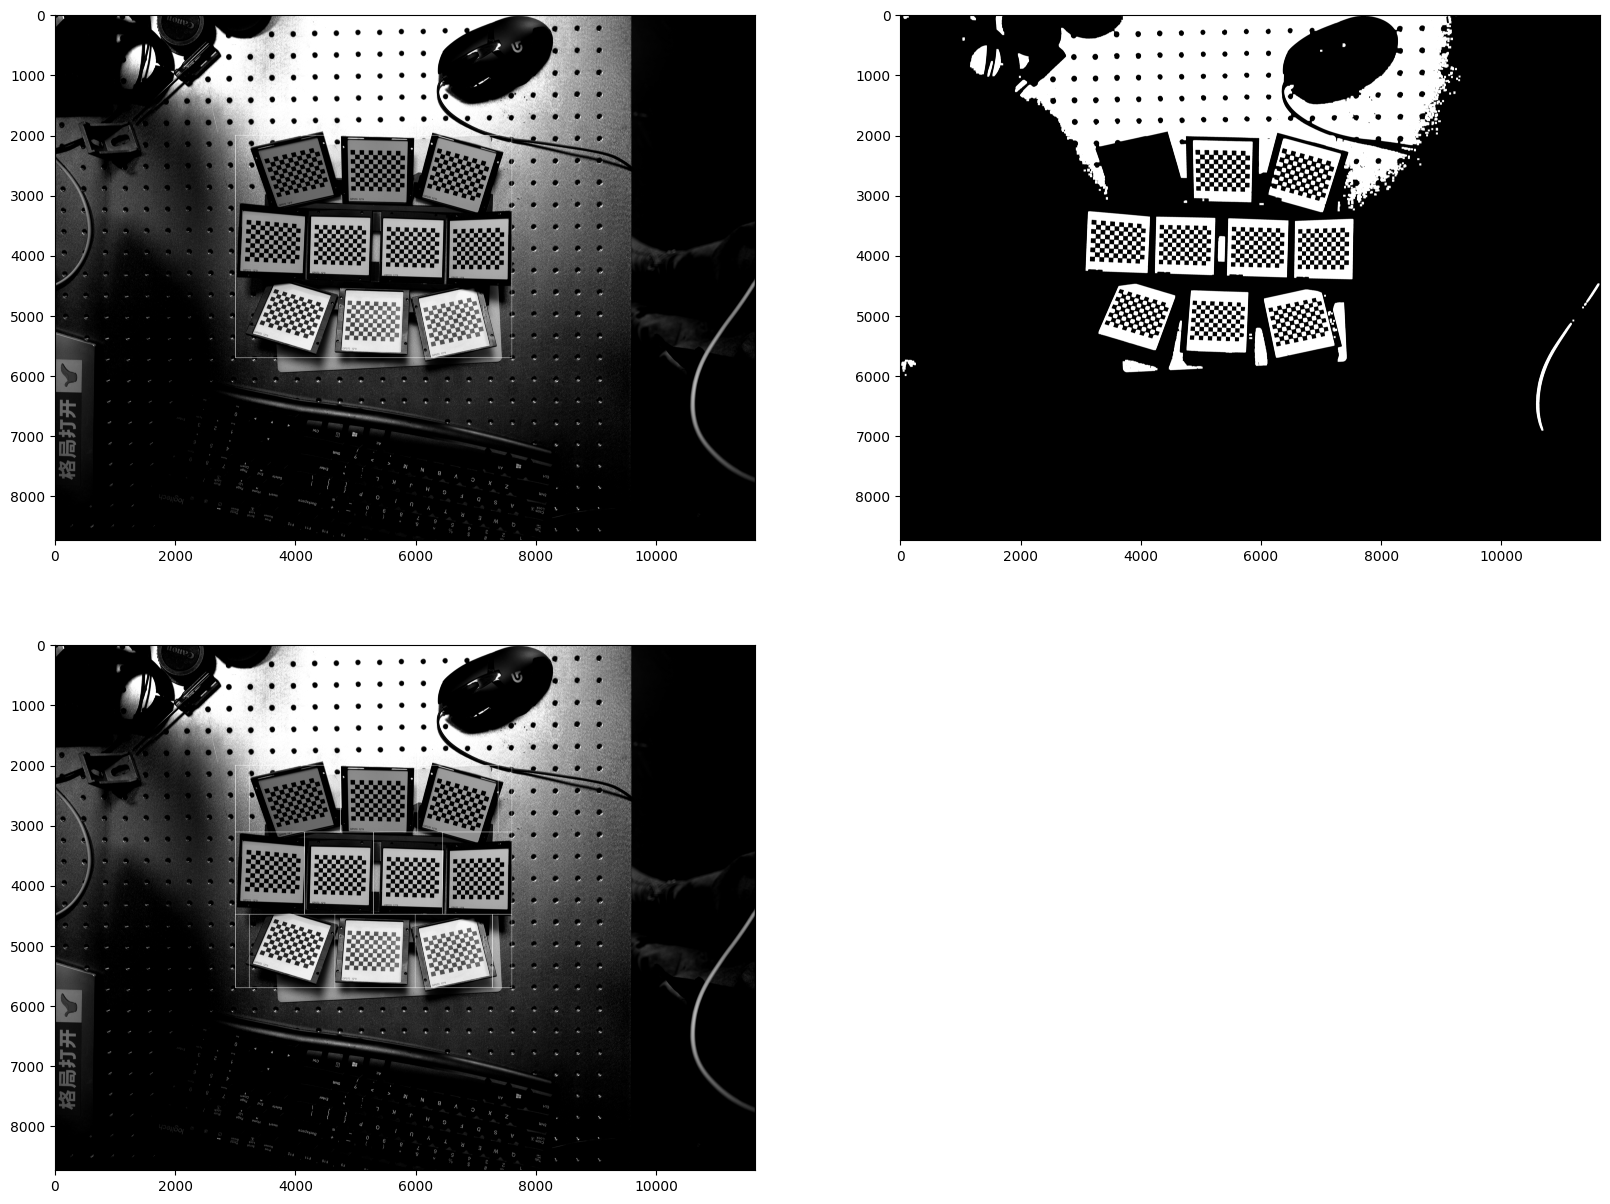

In [5]:
img2 = rawpy.imread(os.path.join(path, cam2)).postprocess(use_camera_wb=True, no_auto_bright=True, output_bps=8)[:8733, :11644]
# increase img contrast
img2 = Image.fromarray(img2)
img2 = ImageEnhance.Contrast(img2).enhance(2)
img2 = np.asarray(img2)

gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# do morphological opening to remove noise and invert image
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=15)

# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# bounding_boxes = np.array([cv2.boundingRect(c) for c in contours])
# bounding_boxes[:, 2:] += bounding_boxes[:, :2]

# x1 = np.min(bounding_boxes[:, 0])
# y1 = np.min(bounding_boxes[:, 1])
# x2 = np.max(bounding_boxes[:, 2])
# y2 = np.max(bounding_boxes[:, 3])

x1, y1, x2, y2 = 3000, 2000, 7600, 5700

h, w = y2-y1, x2-x1
print(x1, y1, x2, y2, h, w)

cv2.rectangle(gray, (x1, y1), (x2, y2), (255, 0, 0), 5)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(gray, cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(thresh, cmap="gray")

h0, h1, h2, h3 = 0, 0.3, 0.67, 1
w0, w1, w2, w3 = 0.05, 0.38, 0.66, 0.95
w4, w5, w6 = 0.25, 0.5, 0.75
w7, w8, w9, w10 = 0.05, 0.36, 0.65, 0.93

cam2_p1 = [
    [[y1+h0*h, x1+w0*w], [y1+h1*h, x1+w1*w]],
    [[y1+h0*h, x1+w1*w], [y1+h1*h, x1+w2*w]],
    [[y1+h0*h, x1+w2*w], [y1+h1*h, x1+w3*w]],

    [[y1+h1*h, x1], [y1+h2*h, x1+w4*w]],
    [[y1+h1*h, x1+w4*w], [y1+h2*h, x1+w5*w]],
    [[y1+h1*h, x1+w5*w], [y1+h2*h, x1+w6*w]],
    [[y1+h1*h, x1+w6*w], [y1+h2*h, x1+w]],

    [[y1+h2*h, x1+w7*w], [y1+h3*h, x1+w8*w]],
    [[y1+h2*h, x1+w8*w], [y1+h3*h, x1+w9*w]],
    [[y1+h2*h, x1+w9*w], [y1+h3*h, x1+w10*w]],
]

# convert to int numpy array
cam2_p1 = np.asarray(cam2_p1, dtype=np.int32)

cam2_p1 = cam2_p1[:, :, ::-1]

for b in cam2_p1:
    cv2.rectangle(gray, b[0], b[1], (255, 0, 0), 5)

plt.subplot(2, 2, 3)
plt.imshow(gray, cmap="gray")

In [6]:
print(img1.shape, img2.shape)
image_list1 = []
image_list2 = []

print("Processing masked images...")
for i in trange(len(cam1_p1)):
    p1, p2 = cam1_p1[i]
    masked_image = generate_masked_image(img1, p1, p2, f"cam1_{i}")
    image_list1.append(img1)
    p1, p2 = cam2_p1[i]
    masked_image = generate_masked_image(img2, p1, p2, f"cam2_{i}")
    image_list2.append(img2)

print("Single calibration...")
ret, k1, d1, _, _ = single_calibrate(image_list1, cam1_p1, square_size=5, path=os.path.join(path, "ref"))
print(ret, k1, d1)

# image_list1_resized = [cv2.resize(img, (img2.shape[1], img2.shape[0])) for img in image_list1]
k1[:2], d1 = k1[:2]/1200*8733, d1/1200*8733

print("Stereo calibration...")
ret, k1_1, d1_1, k2, d2, R, T, E, F = stereo_calibrate(image_list1, image_list2, cam1_p1, cam2_p1, mtx1=k1, dist1=d1, square_size=5, mask = [1, 0], path=os.path.join(path, "ref"))

print(ret)


(1200, 1600, 3) (8733, 11644, 3)
Processing masked images...


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Single calibration...


100%|██████████| 10/10 [00:00<00:00, 46.82it/s]


0.14070820953357355 [[3.07996639e+03 0.00000000e+00 3.55998945e+02]
 [0.00000000e+00 3.06432802e+03 2.58053687e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.15892145  0.00141507 -0.00612556 -0.0146622   0.00829192]]
Stereo calibration...


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


30.80229106570661


In [7]:
print(k1_1)
print(d1_1)
print(k2)
print(d2)
print(R)
print(T)


[[2.24144554e+04 0.00000000e+00 2.59078232e+03]
 [0.00000000e+00 2.23006472e+04 1.87798571e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-1.15655083  0.0102982  -0.04457876 -0.10670417  0.06034443]]
[[2.61433896e+04 0.00000000e+00 5.85712904e+03]
 [0.00000000e+00 3.07735258e+04 4.44100067e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 8.23758536e-02  2.50460155e+00 -8.70000750e-02  8.91940373e-03
  -4.12889402e+01]]
[[ 0.99875115  0.03809644 -0.03232347]
 [-0.02927669  0.97051824  0.23924301]
 [ 0.04048483 -0.2379979   0.97042155]]
[[-296.6463724 ]
 [-350.56681427]
 [1162.01488441]]
